In [51]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

In [53]:
transcript = pd.read_csv('transcripts/transcripts.csv', delimiter='|')
qna =  pd.read_csv('transcripts/QnA.csv', delimiter='|')

# Merge the two dataframes
df = pd.merge(transcript, qna[['transcript','filename']], on='filename')

# rename transcript_x to presentation and transcript_y to QnA
df = df.rename(columns={'transcript_x': 'presentation', 'transcript_y': 'QnA'})

mapping = pd.read_csv('data/mapping.csv')

# create a new column 'AllNames' that concatenates all versions of 'Company' for a 'CompanyName'
mapping['AllNames'] = mapping.groupby('RR_CompanyName')['Transcript_Mapping'].transform(lambda x: ', '.join(x))

# Load recovery rates
rr = pd.read_csv('data/RR_Bonds.csv')
rr = rr[['Ddate', 'RR', 'CompanyName', 'CUSIP', 'LTDIssuance2', 'Intangibility', 'Receivables1']]

preprocessed_df = pd.read_csv('data/preprocessed_bond_data.csv')

# Add rr columns to preprocessed_df on index
preprocessed_df['RR'] = rr['RR']
preprocessed_df['Ddate'] = rr['Ddate']
preprocessed_df['CompanyName'] = rr['CompanyName']
preprocessed_df['CUSIP'] = rr['CUSIP']
preprocessed_df['LTDIssuance2'] = rr['LTDIssuance2']
preprocessed_df['Intangibility'] = rr['Intangibility']
preprocessed_df['Receivables1'] = rr['Receivables1']

rr = preprocessed_df

# Convert 'Date' column to datetime
rr['Ddate'] = pd.to_datetime(rr['Ddate'], errors='coerce')

# merge rr with mapping on CompanyName and RR_CompanyName
rr = rr.merge(mapping, left_on='CompanyName', right_on='RR_CompanyName')

# join with df on Company and Transcripts_Mapping
merged_df = rr.merge(df, left_on='Transcript_Mapping', right_on='Company')

# Ensure the columns are in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Ddate'] = pd.to_datetime(merged_df['Ddate'])

# Compute the difference in days
merged_df['diff'] = (merged_df['Ddate'] - merged_df['Date']).dt.days

merged_df = merged_df[merged_df['Ddate']>merged_df['Date']]
merged_df = merged_df.sort_values(by='Date').groupby(['CUSIP']).tail(1)

In [ ]:
import nltk
from nltk.stem.snowball import SnowballStemmer
import re

# Initialize stemmer
stemmer = SnowballStemmer("english")

# Keywords for each credit factor
credit_keywords = pd.read_csv('data/credit_dictionary.csv')
credit_keywords = credit_keywords['word']

# Function to identify sections with potential bankruptcy indicators
def identify_bankruptcy_indicators(transcript, keywords):
    sentences = nltk.sent_tokenize(transcript)
    indicator_sentences = []
    for sentence in sentences:
        if any(re.search(r'\b' + re.escape(word) + r'\b', sentence, re.IGNORECASE) for word in keywords):
            indicator_sentences.append(sentence)

    return ' '.join(indicator_sentences)

# Function to clean text by stemming and replacing numbers with magnitude tokens
def clean_text(text):
    # Replace numbers with tokens
    text = re.sub(r'\b\d+(\.\d+)?\s?(billion|bln)\b', 'bln', text, flags=re.IGNORECASE)
    text = re.sub(r'\b\d+(\.\d+)?\s?(million|mln)\b', 'mln', text, flags=re.IGNORECASE)
    text = re.sub(r'\b\d{1,3}(,\d{3})*(\.\d+)?\b', 'num', text)  # Replace remaining numbers with 'num'
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize, stem, and rejoin
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words if len(word) > 1]  # Remove single characters that might be noise
    return ' '.join(stemmed_words)

# Transform transcript to lowercase
merged_df['presentation'] = merged_df['presentation'].str.lower()
merged_df['QnA'] = merged_df['QnA'].str.lower()

# Apply function to identify bankruptcy indicators
merged_df['presentation_cleaned'] = merged_df['presentation'].apply(lambda x: identify_bankruptcy_indicators(x, credit_keywords))
merged_df['QnA_cleaned'] = merged_df['QnA'].apply(lambda x: identify_bankruptcy_indicators(x, credit_keywords))

# reset index
merged_df.reset_index(drop=True, inplace=True)

In [121]:
#merged_df.to_csv('transcripts/credit_df.csv', index=False, sep='|')
merged_df = pd.read_csv('transcripts/credit_df.csv', delimiter='|')

In [122]:
df = merged_df.copy()

# add a number to each transcript based on the 196 unique transcripts
df['transcript_number'] = df['presentation_cleaned'].factorize()[0]

number_transcript = df[['transcript_number', 'presentation_cleaned']].drop_duplicates().sort_values('transcript_number')

number_transcript = number_transcript.dropna()

In [123]:
emotion_scores = pd.read_csv('goemotions/emotion_scores.csv')
group_emotion_scores = pd.read_csv('goemotions/group_emotion_scores.csv')

emotion_scores = emotion_scores.rename(columns={'Unnamed: 0': 'transcript_number'})
group_emotion_scores.drop(columns=['Unnamed: 0'], inplace=True)

emotion_scores = emotion_scores.merge(group_emotion_scores, on='transcript_number')

# merge emotion_scores with df on emotion_scores['transcript_number'] == df['transcript_number']
emotion_scores = emotion_scores.merge(df, on='transcript_number')

In [133]:
emotions = [
        #'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        #'approval', 
        #'caring', 
        'confusion', 
        #'curiosity', 
        'desire', 
        #'disappointment', 
        #'disapproval', 
        #'disgust', 
        #'embarrassment', 
        'excitement', 
        'fear', 
        'gratitude', 
        #'grief', 
        #'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        #'realization', 
        #'relief', 
        #'remorse', 
        #'sadness', 
        #'surprise',
        ## Group emotions
        'positive', 'negative', 'ambiguous'
    ]

In [125]:
Strong_Positive = [
    'admiration',
    'excitement',
    'gratitude',
    'pride',
    'relief'
]

Positive = [
    'amusement',
    'approval',
    'caring',
    'optimism'
    ]

Unsure = [
    'confusion',
    'curiosity',
    'desire',
    'realization',
    'surprise',
    'ambiguous'
]

Negative = [
    'annoyance',
    'disappointment',
    'disapproval',
    'embarrassment',
    'nervousness',
    'remorse',
    'sadness'
    ]

Strong_Negative = [
    'anger',
    'fear']

In [126]:
# aggregate emotions
emotion_scores['Strong_Positive'] = emotion_scores[Strong_Positive].sum(axis=1)
emotion_scores['Positive'] = emotion_scores[Positive].sum(axis=1)
emotion_scores['Unsure'] = emotion_scores[Unsure].sum(axis=1)
emotion_scores['Negative'] = emotion_scores[Negative].sum(axis=1)
emotion_scores['Strong_Negative'] = emotion_scores[Strong_Negative].sum(axis=1)
emotion_scores['Sentiment'] = emotion_scores['positive'] - emotion_scores['negative']

# normalize all emotions
emotion_scores['Sentiment'] = (emotion_scores['Sentiment'] - emotion_scores['Sentiment'].mean()) / emotion_scores['Sentiment'].std()
emotion_scores['Strong_Positive'] = (emotion_scores['Strong_Positive'] - emotion_scores['Strong_Positive'].mean()) / emotion_scores['Strong_Positive'].std()
emotion_scores['Positive'] = (emotion_scores['Positive'] - emotion_scores['Positive'].mean()) / emotion_scores['Positive'].std()
emotion_scores['Unsure'] = (emotion_scores['Unsure'] - emotion_scores['Unsure'].mean()) / emotion_scores['Unsure'].std()
emotion_scores['Negative'] = (emotion_scores['Negative'] - emotion_scores['Negative'].mean()) / emotion_scores['Negative'].std()
emotion_scores['Strong_Negative'] = (emotion_scores['Strong_Negative'] - emotion_scores['Strong_Negative'].mean()) / emotion_scores['Strong_Negative'].std()

In [127]:
# normalize all emotions
for emotion in emotions:
    emotion_scores[emotion] = (emotion_scores[emotion] - emotion_scores[emotion].mean()) / emotion_scores[emotion].std()

In [146]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

scores = [
    'Strong_Positive',
    'Positive',
    'Unsure',
    'Negative',
    'Strong_Negative',
    'Sentiment'
]

# Select the supporting features, nlp_lables, and RR from final_df
final_df = emotion_scores[['RR']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    #+ scores
                    + emotions
                    ]

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
final_df.replace('#DIV/0!', np.nan, inplace=True)
final_df = final_df.fillna(0)

# make sure all values are numeric except for the Date column
final_df = final_df.apply(pd.to_numeric, errors='ignore')

final_df.head()

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,RR,anger,annoyance,confusion,desire,excitement,fear,gratitude,nervousness,optimism,pride,positive,negative,ambiguous
0,29.023972,-0.164642,-0.241877,-0.099361,-1.104920,-0.519745,-0.067947,-0.656321,-0.086447,-0.560843,-0.646556,-0.142394,-1.125969,1.343580
1,8.869420,-0.164642,-0.241877,2.453405,-0.580288,-0.519745,-0.067947,-0.656321,-0.086447,1.464127,1.591647,0.781022,0.404042,0.024259
2,33.210455,-0.164642,-0.241877,-0.099361,-1.104920,1.824289,-0.067947,-0.656321,-0.086447,-0.313136,-0.646556,0.590968,0.358954,-0.565785
3,11.875000,-0.164642,-0.241877,-0.099361,-1.104920,-0.519745,-0.067947,6.198511,-0.086447,0.206782,-0.646556,0.904654,0.415940,-0.565785
4,18.340000,-0.164642,-0.241877,-0.099361,-1.104920,-0.519745,-0.067947,-0.656321,-0.086447,0.766607,-0.646556,-0.347216,-1.782233,-0.565785


In [147]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     63.01
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          4.18e-229
Time:                        14:17:13   Log-Likelihood:                -4393.9
No. Observations:                1072   AIC:                             8860.
Df Residuals:                    1036   BIC:                             9039.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

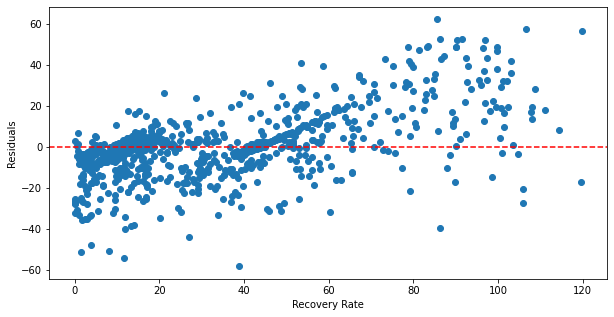

In [140]:
# Bond data 1 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [141]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  3411.819558
17                                Financials    15.390608
11                      ActIndustryDistress1     7.796167
3   Manufacturers inventories to sales ratio     7.417279
4         30 year conventional mortgage rate     7.357408
18                                    Energy     5.368292
12                      ActIndustryDistress2     5.144741
2                    NASDAQ 100 Index return     5.061111
33                                  positive     4.692469
1                 CBOE DJIA Volatility Index     4.496219
6                     Consumer Discretionary     4.153994
5                     Communication Services     3.939450
31                                  optimism     2.835955
20                                 Utilities     2.798477
26                                    desire     2.736233
21                    Information Technology     2.505453
22            

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     63.42
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          1.15e-243
Time:                        14:17:23   Log-Likelihood:                -4349.8
No. Observations:                1072   AIC:                             8780.
Df Residuals:                    1032   BIC:                             8979.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

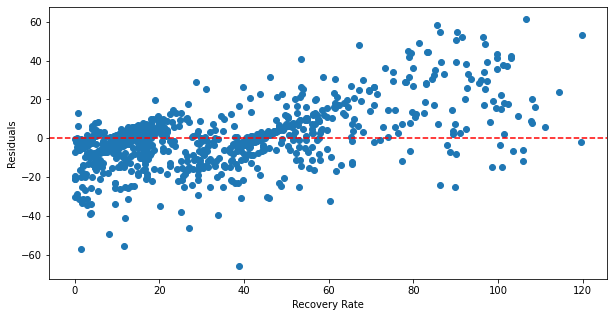

In [144]:
# Bond data 1 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [145]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

                                    Features          VIF
0                                      const  3480.581215
17                                Financials    15.835615
11                      ActIndustryDistress1     8.380070
4         30 year conventional mortgage rate     7.593747
3   Manufacturers inventories to sales ratio     7.577235
18                                    Energy     5.584834
12                      ActIndustryDistress2     5.193126
2                    NASDAQ 100 Index return     5.192731
37                                  positive     4.752304
1                 CBOE DJIA Volatility Index     4.604091
6                     Consumer Discretionary     4.237057
5                     Communication Services     4.050240
35                                  optimism     2.879234
20                                 Utilities     2.833000
30                                    desire     2.820883
21                    Information Technology     2.557388
9             

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     50.73
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          9.07e-102
Time:                        19:52:25   Log-Likelihood:                -4745.6
No. Observations:                1072   AIC:                             9519.
Df Residuals:                    1058   BIC:                             9589.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          34.1659      0.622     54.893      

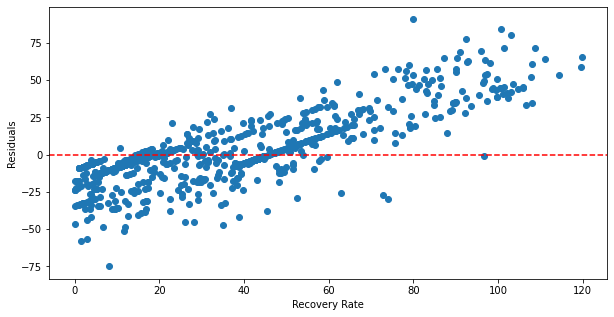

In [148]:
# Bond data 2 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [149]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

       Features       VIF
11     positive  3.367559
9      optimism  2.381542
4        desire  1.764790
10        pride  1.658214
13    ambiguous  1.565637
12     negative  1.419952
7     gratitude  1.368623
3     confusion  1.303121
5    excitement  1.232569
1         anger  1.114834
2     annoyance  1.088171
8   nervousness  1.079335
6          fear  1.073132
0         const  1.000000


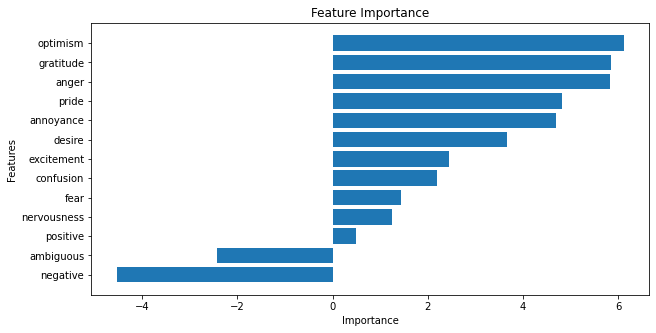

In [156]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()